# Imports

In [8]:
import os
import copy
import math
import json
import random as rnd
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from scipy.linalg import qr

from matplotlib.ticker import NullFormatter

warnings.simplefilter("ignore")

DEVICE = torch.device('cpu')

In [2]:
!nvidia-smi

Fri Nov 22 23:44:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              15W /  55W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Utils

In [9]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample


def plot_samples(X):
  fig = plt.figure(figsize=(8,3), dpi=130)
  grid_img = vision_utils.make_grid(X[:13].cpu(), nrow=13, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter())
  _ = ax.yaxis.set_major_formatter(NullFormatter())
  plt.show()

# Model

In [10]:
class LeNet(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2) # 3 input channels instead of 1
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)
    self.maxPool = nn.MaxPool2d(2,2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.maxPool(F.relu(self.conv1(x)))
    x = self.maxPool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Training utils

In [11]:
def train_model_1(model, opt, train_dl, valid_dl, test_dl, miscolored_test_dl, miscolored_valid_dl, max_epoch=7):

  stats = {'valid_acc': [], 'valid_miscolored_acc': [], 'test_acc': None, 'test_miscolored_acc': None}
  itr = -1
  for epoch in range(max_epoch):
    for x, y in train_dl:
      itr += 1

      loss = F.cross_entropy(model(x), y)

      opt.zero_grad()
      loss.backward()
      opt.step()

      if itr % 60 == 0:
        print_str = f"{epoch}/{itr} \t [train] loss: {loss.item():.2f} "
        valid_acc = get_acc(model, valid_dl)
        valid_miscolored_acc = get_acc(model, miscolored_valid_dl)
        print_str += f"[m1] acc: {valid_acc:.2f}, miscolored-acc: {valid_miscolored_acc:.2f} "
        stats['valid_acc'].append((itr, valid_acc))
        stats['valid_miscolored_acc'].append((itr, valid_miscolored_acc))
        print(print_str)
      
  test_acc = get_acc(model, test_dl)
  test_miscolored_acc = get_acc(model, miscolored_test_dl)
  stats['test_acc'] = test_acc
  stats['test_miscolored_acc'] = test_miscolored_acc
  print(f"[test] acc: {test_acc:.3f}, miscolored-acc: {test_miscolored_acc:.3f}")
  return stats


def train_model_2(model_1, model_2, opt, train_dl, valid_dl, test_dl, perturb_dl, 
                  miscolored_test_dl, miscolored_valid_dl, max_epoch=10, alpha=1):
  miscolored_sampler = dl_to_sampler(perturb_dl)

  stats = {'valid_acc': [], 'valid_miscolored_acc': [], 'test_acc': None, 'test_miscolored_acc': None}

  itr = -1

  for epoch in range(max_epoch):
    for x, y in train_dl:
      itr += 1

      erm_loss = F.cross_entropy(model_2(x), y)

      x_tilde, _ = miscolored_sampler()

      with torch.no_grad():
        p_1 = torch.softmax(model_1(x_tilde), dim=1)
        p_1_1, idx = p_1.max(dim=1)
        p_1_0 = 1. - p_1_1

      p_2 = torch.softmax(model_2(x_tilde), dim=1)
      p_2_1 = p_2[torch.arange(len(p_2)),idx]
      p_2_0 = 1. - p_2_1
      
      adv_loss = (- torch.log( p_1_1 * p_2_0 + p_2_1 * p_1_0 +  1e-7)).mean()

      loss = erm_loss + alpha * adv_loss

      opt.zero_grad()
      loss.backward()
      opt.step()

      if (itr + epoch * len(train_dl)) % 60 == 0:
        print_str = f"{epoch}/{itr} \t [train] erm-loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
        valid_acc = get_acc(model_2, valid_dl)
        valid_miscolored_acc = get_acc(model_2, miscolored_valid_dl)
        print_str += f"[m2] acc: {valid_acc:.2f}, r-acc: {valid_miscolored_acc:.2f} "
        stats['valid_acc'].append((itr, valid_acc))
        stats['valid_miscolored_acc'].append((itr, valid_miscolored_acc))
        print(print_str)
  test_acc = get_acc(model_2, test_dl)
  test_miscolored_acc = get_acc(model_2, miscolored_test_dl)
  stats['test_acc'] = test_acc
  stats['test_miscolored_acc'] = test_miscolored_acc
  print(f"[test] acc: {test_acc:.3f}, r-acc: {test_miscolored_acc:.3f}")
  return stats

# Build C-MNIST dataset with $\mathcal{D}_\text{ood} = \mathcal{D}_\text{test}$

In [12]:
train_set = torchvision.datasets.MNIST('./data/mnist/', train = True, download = True)
train_input  = train_set.train_data.view(-1, 1, 28, 28).to(DEVICE).float()
train_target = train_set.train_labels.to(DEVICE)

test_set = torchvision.datasets.MNIST('./data/mnist/', train = False, download = True)
test_input = test_set.test_data.view(-1, 1, 28, 28).to(DEVICE).float()
test_target = test_set.test_labels.to(DEVICE)

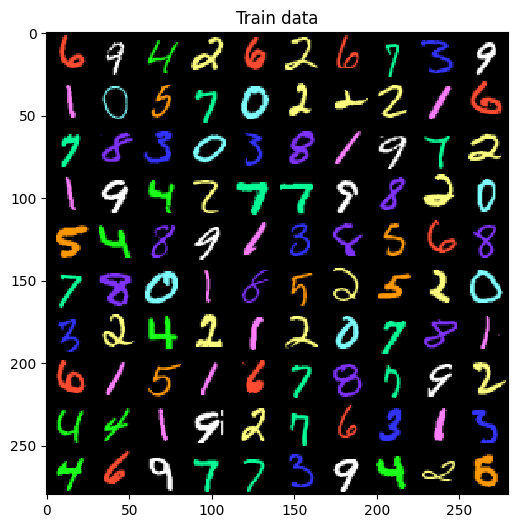

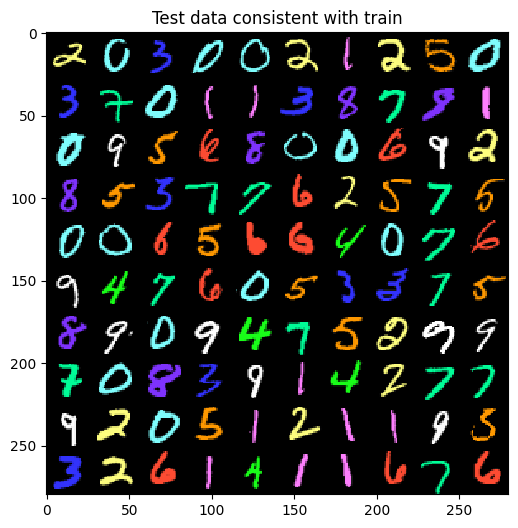

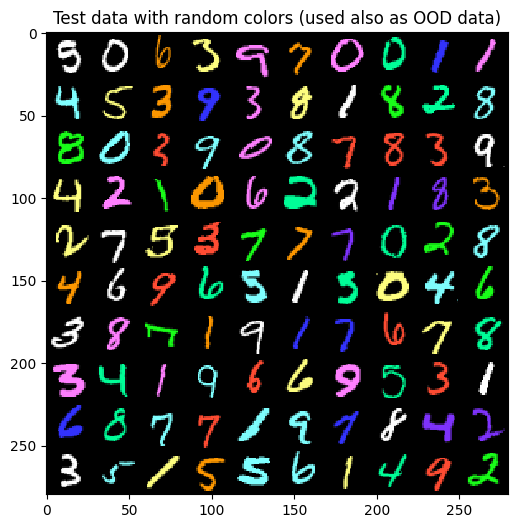

In [13]:
def color_train_digits(X, Y):
  res = []
  for x, y in zip(X, Y):
    x = x / 255
    mask = x.view(28,28) > 0.1
    img = x.repeat(3, 1, 1)
    if y == 0:
      img[0][mask] *= 0.5
    elif y == 1:
      img[1][mask] *= 0.5
    elif y == 2:
      img[2][mask] *= 0.5
    elif y == 3:
      img[0][mask] *= 0.2
      img[1][mask] *= 0.2
    elif y == 4:
      img[0][mask] *= 0.1
      img[2][mask] *= 0.1
    elif y == 5:
      img[1][mask] *= 0.6
      img[2][mask] *= 0.
    elif y == 6:
      img[1][mask] *= 0.3
      img[2][mask] *= 0.2
    elif y == 7:
      img[0][mask] *= 0.
      img[2][mask] *= 0.6
    elif y == 8:
      img[0][mask] *= 0.5
      img[1][mask] *= 0.2
    else:
      pass
    res.append(img.clip(0,1))
  res = torch.stack(res)
  return res


def color_test_digits(X, Y):
  res = []
  for x, y in zip(X, Y):
    x = x / 255
    mask = x.view(28,28) > 0.1
    img = x.repeat(3, 1, 1)
    color_idx = rnd.randint(0, 9)
    if color_idx == 9:
      img[0][mask] *= 0.5
    elif color_idx == 8:
      img[1][mask] *= 0.5
    elif color_idx == 7:
      img[2][mask] *= 0.5
    elif color_idx == 6:
      img[0][mask] *= 0.2
      img[1][mask] *= 0.2
    elif color_idx == 5:
      img[0][mask] *= 0.1
      img[2][mask] *= 0.1
    elif color_idx == 4:
      img[1][mask] *= 0.6
      img[2][mask] *= 0.
    elif color_idx == 3:
      img[1][mask] *= 0.3
      img[2][mask] *= 0.2
    elif color_idx == 2:
      img[0][mask] *= 0.
      img[2][mask] *= 0.6
    elif color_idx == 1:
      img[0][mask] *= 0.5
      img[1][mask] *= 0.2
    else:
      pass
    res.append(img.clip(0,1))
  res = torch.stack(res)
  return res


rand_perm = torch.randperm(len(train_input))
train_input = train_input[rand_perm]
train_target = train_target[rand_perm]

rand_perm = torch.randperm(len(test_input))
test_input = test_input[rand_perm]
test_target = test_target[rand_perm]

valid_input, valid_target = train_input[:3000], train_target[:3000]
valid_miscolored_input, valid_miscolored_target = train_input[3000:6000], train_target[3000:6000]
train_input, train_target = train_input[6000:], train_target[6000:]

test_miscolored_input, test_miscolored_target = test_input[:2000], test_target[:2000]
perturbation_input, perturbation_target = test_input[2000:8000], test_target[2000:8000]
test_input, test_target = test_input[8000:], test_target[8000:]

valid_input = color_train_digits(valid_input, valid_target)
train_input = color_train_digits(train_input, train_target)
test_input = color_train_digits(test_input, test_target)

valid_miscolored_input = color_test_digits(valid_miscolored_input, valid_miscolored_target)
test_miscolored_input = color_test_digits(test_miscolored_input, test_miscolored_target)
perturbation_input = color_test_digits(perturbation_input, perturbation_target)

colored_train_input = train_input
colored_test_input = test_input
miscolored_test_input = perturbation_input

fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((colored_train_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Train data')

fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((colored_test_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Test data consistent with train')

fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((miscolored_test_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Test data with random colors (used also as OOD data)')

In [14]:
# Normal training set / valid and test set
train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
valid_dataset = torch.utils.data.TensorDataset(valid_input, valid_target)
test_dataset = torch.utils.data.TensorDataset(test_input, test_target)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=1024, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Perturbation dl
perturb_dataset = torch.utils.data.TensorDataset(perturbation_input, perturbation_target)
perturb_dl = torch.utils.data.DataLoader(perturb_dataset, batch_size=256, shuffle=True)

# Random color valid and test
miscolored_valid_dataset = torch.utils.data.TensorDataset(valid_miscolored_input, valid_miscolored_target)
miscolored_test_dataset = torch.utils.data.TensorDataset(test_miscolored_input, test_miscolored_target)
miscolored_valid_dl = torch.utils.data.DataLoader(miscolored_valid_dataset, batch_size=1024, shuffle=False)
miscolored_test_dl = torch.utils.data.DataLoader(miscolored_test_dataset, batch_size=1024, shuffle=False)

In [15]:
all_stats = []
for i in range(10):
  model_1 = LeNet().to(DEVICE)
  opt = torch.optim.Adam(model_1.parameters(), lr=0.005)
  stats_m1 = train_model_1(model_1, opt, train_dl, valid_dl, test_dl, miscolored_test_dl, miscolored_valid_dl, max_epoch=7)

  model_2 = LeNet().to(DEVICE)
  opt = torch.optim.SGD(model_2.parameters(), lr=0.005, momentum=0.9)
  stats_m2 = train_model_2(model_1, model_2, opt, train_dl, valid_dl, test_dl, perturb_dl, miscolored_test_dl, 
                           miscolored_valid_dl, max_epoch=7, alpha=2)
  all_stats.append((stats_m1, stats_m2))

0/0 	 [train] loss: 2.30 [m1] acc: 0.12, miscolored-acc: 0.10 
0/60 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.17 
0/120 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.14 
0/180 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.13 
1/240 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.12 
1/300 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
1/360 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
1/420 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
2/480 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
2/540 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
2/600 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
3/660 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
3/720 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
3/780 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
3/840 	 [train] loss: 0.00 [m1] acc: 1.00, miscolored-acc: 0.11 
4/900 	 [train] loss: 0.00 [

# Build C-MNIST dataset with $\mathcal{D}_\text{ood} \neq \mathcal{D}_\text{test}$

In [8]:
train_set = torchvision.datasets.MNIST('./data/mnist/', train = True, download = True)
train_input  = train_set.train_data.view(-1, 1, 28, 28).to(DEVICE).float()
train_target = train_set.train_labels.to(DEVICE)

test_set = torchvision.datasets.MNIST('./data/mnist/', train = False, download = True)
test_input = test_set.test_data.view(-1, 1, 28, 28).to(DEVICE).float()
test_target = test_set.test_labels.to(DEVICE)

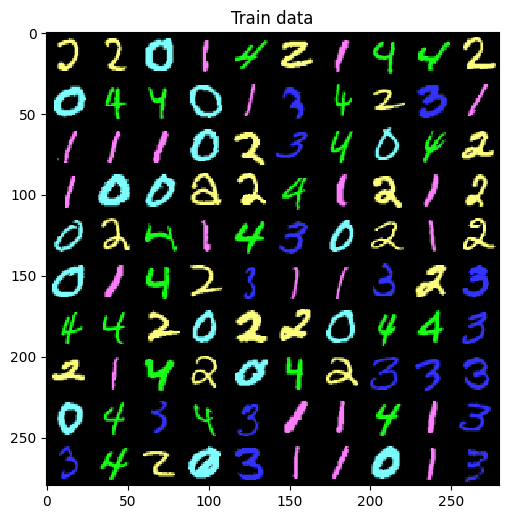

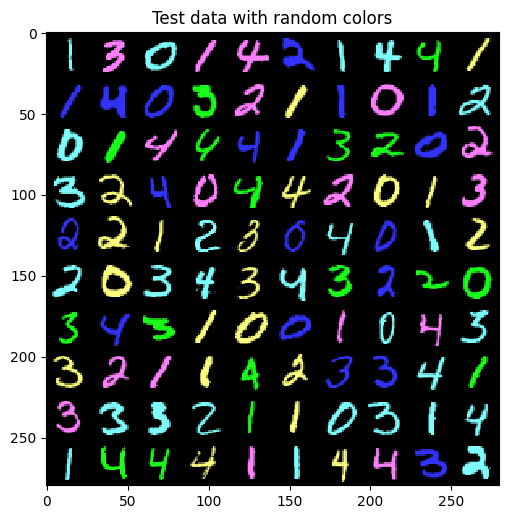

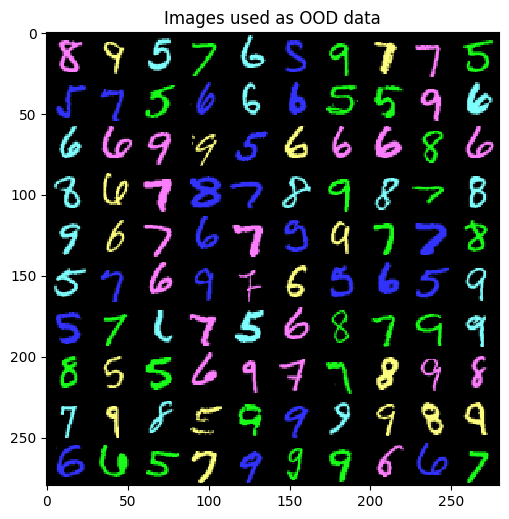

In [9]:
def color_train_digits(X, Y):
  res_train, y_train, res_ood, y_ood = [], [], [], []
  for x, y in zip(X, Y):
    x = x / 255
    mask = x.view(28,28) > 0.1
    img = x.repeat(3, 1, 1)
    if y == 0:
      img[0][mask] *= 0.5
    elif y == 1:
      img[1][mask] *= 0.5
    elif y == 2:
      img[2][mask] *= 0.5
    elif y == 3:
      img[0][mask] *= 0.2
      img[1][mask] *= 0.2
    elif y == 4:
      img[0][mask] *= 0.1
      img[2][mask] *= 0.1
    elif y == 5:
      img[1][mask] *= 0.6
      img[2][mask] *= 0.
    elif y == 6:
      img[1][mask] *= 0.3
      img[2][mask] *= 0.2
    elif y == 7:
      img[0][mask] *= 0.
      img[2][mask] *= 0.6
    elif y == 8:
      img[0][mask] *= 0.5
      img[1][mask] *= 0.2
    else:
      pass
    if y in [0,1,2,3,4]:
      y_train.append(y)
      res_train.append(img.clip(0,1))
    else:
      y_ood.append(y-5)
      res_ood.append(img.clip(0,1))
  res_train = torch.stack(res_train)
  res_ood = torch.stack(res_ood)
  return res_train, torch.tensor(y_train).to(res_train.device), res_ood, torch.tensor(y_ood).to(res_train.device)


def color_test_digits(X, Y):
  res_test, y_test, res_ood, y_ood = [], [], [], []
  for x, y in zip(X, Y):
    x = x / 255
    mask = x.view(28,28) > 0.1
    img = x.repeat(3, 1, 1)
    if y in [0,1,2,3,4]:
      #color_idx = rnd.randint(5, 10)
      color_idx = rnd.randint(0, 4)
    else:
      color_idx = rnd.randint(0, 4)
      #color_idx = rnd.randint(6, 9)
    if color_idx == 0:
      img[0][mask] *= 0.5
    elif color_idx == 1:
      img[1][mask] *= 0.5
    elif color_idx == 2:
      img[2][mask] *= 0.5
    elif color_idx == 3:
      img[0][mask] *= 0.2
      img[1][mask] *= 0.2
    elif color_idx == 4:
      img[0][mask] *= 0.1
      img[2][mask] *= 0.1
    elif color_idx == 5:
      img[1][mask] *= 0.6
      img[2][mask] *= 0.
    elif color_idx == 6:
      img[1][mask] *= 0.3
      img[2][mask] *= 0.2
    elif color_idx == 7:
      img[0][mask] *= 0.
      img[2][mask] *= 0.6
    elif color_idx == 8:
      img[0][mask] *= 0.5
      img[1][mask] *= 0.2
    else:
      pass
    if y in [0,1,2,3,4]:
      y_test.append(y)
      res_test.append(img.clip(0,1))
    else:
      y_ood.append(y-5)
      res_ood.append(img.clip(0,1))
  res_test = torch.stack(res_test)
  res_ood = torch.stack(res_ood)
  return res_test, torch.tensor(y_test).to(res_test.device), res_ood, torch.tensor(y_ood).to(res_test.device)



rand_perm = torch.randperm(len(train_input))
train_input = train_input[rand_perm]
train_target = train_target[rand_perm]

rand_perm = torch.randperm(len(test_input))
test_input = test_input[rand_perm]
test_target = test_target[rand_perm]

valid_input, valid_target = train_input[:3000], train_target[:3000]
valid_miscolored_input, valid_miscolored_target = train_input[3000:6000], train_target[3000:6000]
train_input, train_target = train_input[6000:], train_target[6000:]

test_miscolored_input, test_miscolored_target = test_input[:2000], test_target[:2000]
perturbation_input, perturbation_target = test_input[2000:8000], test_target[2000:8000]
test_input, test_target = test_input[8000:], test_target[8000:]

valid_input, valid_target, _, _ = color_train_digits(valid_input, valid_target)
train_input, train_target, _, _ = color_train_digits(train_input, train_target)
test_input, test_target, _, _ = color_train_digits(test_input, test_target)

valid_miscolored_input, valid_miscolored_target, _, _ = color_test_digits(valid_miscolored_input, valid_miscolored_target)
test_miscolored_input, test_miscolored_target, _, _ = color_test_digits(test_miscolored_input, test_miscolored_target)
_, _, perturbation_input, perturbation_target = color_test_digits(perturbation_input, perturbation_target)



fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((train_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Train data')

fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((test_miscolored_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Test data with random colors')

fig = plt.figure(figsize=(6,6), dpi=100)
grid_img = vision_utils.make_grid((perturbation_input[:100]).cpu(), 
                                  nrow=10, 
                                  normalize=True, 
                                  padding=0)
_ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
_ = plt.title('Images used as OOD data')

In [ ]:
# Normal training set / valid and test set
train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
valid_dataset = torch.utils.data.TensorDataset(valid_input, valid_target)
test_dataset = torch.utils.data.TensorDataset(test_input, test_target)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=1024, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Perturbation dl
perturb_dataset = torch.utils.data.TensorDataset(perturbation_input, perturbation_target)
perturb_dl = torch.utils.data.DataLoader(perturb_dataset, batch_size=256, shuffle=True)

# Random color valid and test
miscolored_valid_dataset = torch.utils.data.TensorDataset(valid_miscolored_input, valid_miscolored_target)
miscolored_test_dataset = torch.utils.data.TensorDataset(test_miscolored_input, test_miscolored_target)
miscolored_valid_dl = torch.utils.data.DataLoader(miscolored_valid_dataset, batch_size=1024, shuffle=False)
miscolored_test_dl = torch.utils.data.DataLoader(miscolored_test_dataset, batch_size=1024, shuffle=False)

In [ ]:
all_stats = []
for i in range(10):
  model_1 = LeNet().to(DEVICE)
  opt = torch.optim.Adam(model_1.parameters(), lr=0.005)
  stats_m1 = train_model_1(model_1, opt, train_dl, valid_dl, test_dl, miscolored_test_dl, miscolored_valid_dl, max_epoch=7)

  model_2 = LeNet().to(DEVICE)
  opt = torch.optim.SGD(model_2.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.8)
  stats_m2 = train_model_2(model_1, model_2, opt, train_dl, valid_dl, test_dl, perturb_dl, miscolored_test_dl, 
                           miscolored_valid_dl, max_epoch=30, alpha=2)
  all_stats.append((stats_m1, stats_m2))